In [1]:
import tensorflow as tf
import numpy as np
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

#config = tf.ConfigProto(gpu_options=tf.GPUOptions(visible_device_list="1", allow_growth=True))

# load a color image with low resolution
img = imageio.imread('input_SR_sailboat_low_res_128.png')

N1 = img.shape[0]
N2 = img.shape[1]
C  = img.shape[2]
N3 = img.shape[2]

tau = 6   # window size of delay embedding (patch size)
r   = 32  # dimension of manifold
sig = 0.1 # noise level for denoising auto-encoder


In [2]:
# define functions

# making one-hot filters
def make_embfilter(tau):
    fil = np.zeros([tau,tau,1,tau*tau])
    tij = 0
    for ti in range(tau):
        for tj in range(tau):
            fil[ti,tj,0,tij] = 1
            tij = tij+1
    return fil
Hfil = make_embfilter(tau)
Hfil = Hfil.astype('float32')

pad_para_emb   = [[0,0],[tau-1,tau-1],[tau-1,tau-1],[0,0]]
pad_type_emb   = 'reflect'

# delay-embedding layer
def H(z):
    z = tf.pad(z,pad_para_emb,pad_type_emb)
    return tf.nn.conv2d(z,Hfil,strides=[1,1,1,1],padding='VALID')

# inverse delay-embedding layer
def Hinv(z):
    z_size = np.array(z.shape,dtype='int32')
    Htz = tf.nn.conv2d_transpose(z,Hfil,output_shape=[z_size[0],
                                                      z_size[1]+tau-1,
                                                      z_size[2]+tau-1,
                                                      Hfil.shape[2]],strides=[1,1,1,1],padding='VALID')
    return Htz[:,tau-1:z_size[1],tau-1:z_size[2],:]/tau/tau


## autoencoder (with 3 hidden layers)
def NN(data,ranks):
    Z0 = tf.layers.dense(data,ranks[0])
    Z0 = tf.nn.leaky_relu(Z0)
    Z1 = tf.layers.dense(Z0,ranks[1])
    Z1 = tf.nn.leaky_relu(Z1)
    Z2 = tf.layers.dense(Z1,ranks[2])
    Z2 = tf.nn.leaky_relu(Z2)
    Z3 = tf.layers.dense(Z2,data.shape[1])
    return Z3

In [3]:
# making Lanczos kernel for super resolution

factor = 4
support= 2
kernel_width = 4*factor
kernel = np.zeros([kernel_width, kernel_width], dtype='float32')
center = (kernel_width) / 2. + 1.
for i in range(1, kernel.shape[0] + 1):
    for j in range(1, kernel.shape[1] + 1):
        di = abs(i + 0.5 - center) / factor  
        dj = abs(j + 0.5 - center) / factor 
        #dij = np.sqrt(di*di + dj*dj)
        
        pi_sq = np.pi * np.pi
        val = 1
        if di != 0:
            val = val * support * np.sin(np.pi * di) * np.sin(np.pi * di / support)
            val = val / (np.pi * np.pi * di * di)
            
        if dj != 0:
            val = val * support * np.sin(np.pi * dj) * np.sin(np.pi * dj / support)
            val = val / (np.pi * np.pi * dj * dj)
            
        kernel[i - 1][j - 1] = val

kernel = kernel / np.sum(kernel)
kernel = np.reshape(kernel,[kernel_width,kernel_width,1,1])

pad_para   = [[0,0],[1,1],[1,1],[0,0]]
pad_type   = 'symmetric'


In [4]:
## problem def

#dimensions of hidden layers in denoising auto-encoder 
ranks = [8*tau*tau, r, 8*tau*tau]

up = factor

X = tf.Variable(tf.random_uniform([C,up*N2,up*N1,1], dtype=tf.float32))
Hx=tf.transpose(tf.reshape(tf.transpose(H(X)),[tau*tau,C*(up*N2+tau-1)*(up*N1+tau-1)]))
noise= tf.random_normal(Hx.shape,0.0,sig,dtype=tf.float32)
AHx  = NN(Hx+noise,ranks)
Xrec = Hinv(tf.transpose(tf.reshape(tf.transpose(AHx),[tau*tau,up*N1+tau-1,up*N2+tau-1,C])))

Yup  = tf.sigmoid(tf.transpose(tf.layers.conv2d(tf.transpose(Xrec),filters=N3,kernel_size=[1,1],padding="same",strides=(1,1))))

padded = Yup
for t in range(6):
    padded = tf.pad(padded, pad_para, pad_type)

Ydw = tf.nn.conv2d(padded,kernel,strides=[1,up,up,1],padding='VALID')
label_node = tf.placeholder(tf.float32,shape=(N3,N2,N1,1))
lam_ph = tf.placeholder(tf.float32,())

rec_loss  = tf.losses.mean_squared_error(label_node, Ydw)
ae_loss1  = tf.losses.mean_squared_error(Hx, AHx)

ae_loss   = lam_ph/tau/tau*( ae_loss1 )
cost = rec_loss + ae_loss


BATCH_SIZE = 1

batch = tf.Variable(0)
learning_rate = tf.train.exponential_decay(
    0.01,                 # Base learning rate.
    batch*BATCH_SIZE,     # Current index into the dataset.
    100,                  # Decay step.
    0.98,                 # Decay rate.
    staircase=True)

update = tf.train.AdamOptimizer(learning_rate).minimize(cost, global_step=batch)

init = tf.global_variables_initializer()



Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


<IPython.core.display.Javascript object>


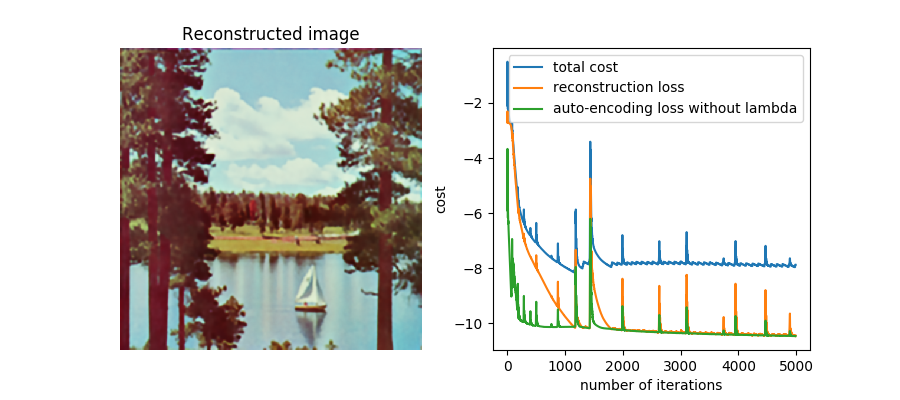

In [5]:
%matplotlib notebook
fig = plt.figure(figsize=(9,4),dpi=100)
ax2 = fig.add_subplot(1,2,1)
ax3 = fig.add_subplot(1,2,2)


In [6]:
import time
import random
import scipy.io
#from scipy import misc
import imageio

num_iter = 5000
cost_hist = np.zeros([num_iter,3])
start_time = time.time()

sc = 255.0

# reshape
label_data = np.transpose(np.reshape(img.astype(np.float32),[1,N1,N2,N3])/sc)

lam = 20.0 # initial value of lambda (this is adjustable)
with tf.Session(config=config) as sess:
    sess.run(init)
    print('Iinitialized!')
    for step in range(0,num_iter):
        _, cost_value,cost_rec,cost_ae, y_est, x_est = sess.run([update,cost,rec_loss,ae_loss,Yup,X],{label_node:label_data,lam_ph:lam})
        l_rate = sess.run(learning_rate)
        cost_hist[step,0] = cost_value
        cost_hist[step,1] = cost_rec
        cost_hist[step,2] = cost_ae/lam
        yt = np.transpose(np.reshape(255.0*y_est,[3,up*N2,up*N1]))                              
        if step %10 == 0:
            elapsed_time = time.time() - start_time
            start_time   = time.time()
            if cost_rec < cost_ae/lam:
                lam = lam*1.1
            elif cost_ae/lam < cost_rec:
                lam = lam*0.99
            print('Step %d / %d :: %f :: %f :: %f' % (step,num_iter,cost_value,l_rate,lam))
            ax2.clear()
            ax2.imshow(np.transpose(np.reshape(255.0*y_est,[3,up*N2,up*N1])).astype(np.uint8))
            ax2.set_title("Reconstructed image")
            ax2.axis("off")
            ax3.clear()
            ax3.plot(np.log(cost_hist[0:step,0]), label="total cost")
            ax3.plot(np.log(cost_hist[0:step,1]), label="reconstruction loss")
            ax3.plot(np.log(cost_hist[0:step,2]), label="auto-encoding loss without lambda")
            ax3.legend()
            ax3.set_xlabel("number of iterations")
            ax3.set_ylabel("cost")
            fig.canvas.draw()
imageio.imsave('output_SR.png',np.transpose(np.reshape(255.0*y_est,[3,up*N2,up*N1])).astype(np.uint8))


Iinitialized!
Step 0 / 5000 :: 0.259022 :: 0.010000 :: 19.800000
Step 10 / 5000 :: 0.127328 :: 0.010000 :: 19.602000
Step 20 / 5000 :: 0.095013 :: 0.010000 :: 19.405980
Step 30 / 5000 :: 0.082631 :: 0.010000 :: 19.211920
Step 40 / 5000 :: 0.074335 :: 0.010000 :: 19.019801
Step 50 / 5000 :: 0.068694 :: 0.010000 :: 18.829603
Step 60 / 5000 :: 0.063894 :: 0.010000 :: 18.641307
Step 70 / 5000 :: 0.057830 :: 0.010000 :: 18.454894
Step 80 / 5000 :: 0.050116 :: 0.010000 :: 18.270345
Step 90 / 5000 :: 0.044801 :: 0.010000 :: 18.087642
Step 100 / 5000 :: 0.032812 :: 0.009800 :: 17.906765
Step 110 / 5000 :: 0.024794 :: 0.009800 :: 17.727697
Step 120 / 5000 :: 0.018934 :: 0.009800 :: 17.550420
Step 130 / 5000 :: 0.014459 :: 0.009800 :: 17.374916
Step 140 / 5000 :: 0.011222 :: 0.009800 :: 17.201167
Step 150 / 5000 :: 0.008846 :: 0.009800 :: 17.029155
Step 160 / 5000 :: 0.006920 :: 0.009800 :: 16.858864
Step 170 / 5000 :: 0.005349 :: 0.009800 :: 16.690275
Step 180 / 5000 :: 0.006240 :: 0.009800 :: 

Step 1550 / 5000 :: 0.000558 :: 0.007386 :: 10.763110
Step 1560 / 5000 :: 0.000539 :: 0.007386 :: 10.655479
Step 1570 / 5000 :: 0.000523 :: 0.007386 :: 10.548924
Step 1580 / 5000 :: 0.000508 :: 0.007386 :: 10.443435
Step 1590 / 5000 :: 0.000494 :: 0.007386 :: 10.339000
Step 1600 / 5000 :: 0.000480 :: 0.007238 :: 10.235610
Step 1610 / 5000 :: 0.000469 :: 0.007238 :: 10.133254
Step 1620 / 5000 :: 0.000458 :: 0.007238 :: 10.031922
Step 1630 / 5000 :: 0.000449 :: 0.007238 :: 9.931602
Step 1640 / 5000 :: 0.000440 :: 0.007238 :: 9.832286
Step 1650 / 5000 :: 0.000432 :: 0.007238 :: 9.733964
Step 1660 / 5000 :: 0.000425 :: 0.007238 :: 9.636624
Step 1670 / 5000 :: 0.000418 :: 0.007238 :: 9.540258
Step 1680 / 5000 :: 0.000411 :: 0.007238 :: 9.444855
Step 1690 / 5000 :: 0.000405 :: 0.007238 :: 9.350407
Step 1700 / 5000 :: 0.000399 :: 0.007093 :: 9.256902
Step 1710 / 5000 :: 0.000393 :: 0.007093 :: 9.164333
Step 1720 / 5000 :: 0.000388 :: 0.007093 :: 9.072690
Step 1730 / 5000 :: 0.000383 :: 0.0070

Step 3080 / 5000 :: 0.000391 :: 0.005455 :: 11.232719
Step 3090 / 5000 :: 0.000387 :: 0.005455 :: 12.355991
Step 3100 / 5000 :: 0.000650 :: 0.005346 :: 12.232431
Step 3110 / 5000 :: 0.000429 :: 0.005346 :: 12.110107
Step 3120 / 5000 :: 0.000431 :: 0.005346 :: 11.989006
Step 3130 / 5000 :: 0.000413 :: 0.005346 :: 11.869116
Step 3140 / 5000 :: 0.000411 :: 0.005346 :: 11.750425
Step 3150 / 5000 :: 0.000406 :: 0.005346 :: 11.632920
Step 3160 / 5000 :: 0.000399 :: 0.005346 :: 11.516591
Step 3170 / 5000 :: 0.000395 :: 0.005346 :: 11.401425
Step 3180 / 5000 :: 0.000391 :: 0.005346 :: 11.287411
Step 3190 / 5000 :: 0.000386 :: 0.005346 :: 11.174537
Step 3200 / 5000 :: 0.000383 :: 0.005239 :: 12.291991
Step 3210 / 5000 :: 0.000417 :: 0.005239 :: 12.169071
Step 3220 / 5000 :: 0.000413 :: 0.005239 :: 12.047380
Step 3230 / 5000 :: 0.000409 :: 0.005239 :: 11.926906
Step 3240 / 5000 :: 0.000405 :: 0.005239 :: 11.807637
Step 3250 / 5000 :: 0.000401 :: 0.005239 :: 11.689561
Step 3260 / 5000 :: 0.000397

Step 4600 / 5000 :: 0.000377 :: 0.003948 :: 11.841231
Step 4610 / 5000 :: 0.000373 :: 0.003948 :: 11.722818
Step 4620 / 5000 :: 0.000370 :: 0.003948 :: 11.605590
Step 4630 / 5000 :: 0.000366 :: 0.003948 :: 11.489534
Step 4640 / 5000 :: 0.000363 :: 0.003948 :: 11.374639
Step 4650 / 5000 :: 0.000359 :: 0.003948 :: 11.260892
Step 4660 / 5000 :: 0.000356 :: 0.003948 :: 12.386982
Step 4670 / 5000 :: 0.000388 :: 0.003948 :: 12.263112
Step 4680 / 5000 :: 0.000384 :: 0.003948 :: 12.140481
Step 4690 / 5000 :: 0.000381 :: 0.003948 :: 12.019076
Step 4700 / 5000 :: 0.000377 :: 0.003869 :: 11.898885
Step 4710 / 5000 :: 0.000373 :: 0.003869 :: 11.779896
Step 4720 / 5000 :: 0.000370 :: 0.003869 :: 11.662097
Step 4730 / 5000 :: 0.000366 :: 0.003869 :: 11.545476
Step 4740 / 5000 :: 0.000363 :: 0.003869 :: 11.430022
Step 4750 / 5000 :: 0.000359 :: 0.003869 :: 11.315721
Step 4760 / 5000 :: 0.000355 :: 0.003869 :: 12.447294
Step 4770 / 5000 :: 0.000388 :: 0.003869 :: 12.322821
Step 4780 / 5000 :: 0.000385